https://web.stanford.edu/~boyd/papers/pdf/cvx_portfolio.pdf



In [14]:
%matplotlib inline

import cvxportfolio as cp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from research_tools.research_tools import run_pipeline, get_pricing, get_symbols
from research_tools.ics.ics_scheme import Sector
from zipline.pipeline.data import USEquityPricing as USEP
from zipline.pipeline.factors import Returns, AverageDollarVolume, AnnualizedVolatility
from zipline.pipeline import Pipeline

In [15]:
universe = AverageDollarVolume(window_length=120).top(500)
my_factor = (
    -Returns(mask=universe, window_length=5).
    demean(groupby=Sector()).
    rank().
    zscore()
)

p = Pipeline(screen=universe)
p.add(Sector(), 'Sector')
p.add(AnnualizedVolatility(window_length=120, mask=universe), "Volatility")
p.add(USEP.close.latest, "Price")
p.add(my_factor, '5d_MR_Sector_Neutral_Rank')

start_date = '2017-01-04'
end_date = '2017-01-04'

df = run_pipeline(p, start_date, end_date)

In [16]:
df['expec_return'] = 0.02*df['5d_MR_Sector_Neutral_Rank']*df['Volatility']/np.sqrt(252)

In [17]:
df.expec_return.max()

0.00265080291491987

In [18]:
df.index = df.index.droplevel(0)

In [19]:
df.dropna(inplace=True)

In [20]:
df.head()

,5d_MR_Sector_Neutral_Rank,Price,Sector,Volatility,expec_return
Equity(0 [A]),-0.371702,46.49,0,0.210912,-0.000099
Equity(2 [AAL]),1.659247,46.30,2,0.293127,0.000613
Equity(7 [AAP]),-0.478998,170.60,2,0.295419,-0.000178
Equity(8 [AAPL]),0.869860,116.15,6,0.195097,0.000214
Equity(12 [ABBV]),0.149447,62.41,0,0.230412,0.000043


In [21]:
symbols = list(df.index.values)

In [22]:
symbols = symbols

In [23]:
r_hat = pd.DataFrame(
    index=symbols,
    columns=[end_date],
    data=df.expec_return.values
).T

In [24]:
r_hat

,Equity(0 [A]),Equity(2 [AAL]),Equity(7 [AAP]),Equity(8 [AAPL]),Equity(12 [ABBV]),Equity(13 [ABC]),Equity(20 [ABT]),Equity(37 [ACN]),Equity(45 [ADBE]),Equity(48 [ADI]),...,Equity(3148 [XEC]),Equity(3149 [XEL]),Equity(3151 [XLNX]),Equity(3156 [XOM]),Equity(3163 [XRAY]),Equity(3171 [YELP]),Equity(3175 [YUM]),Equity(3180 [ZBH]),Equity(3188 [ZION]),Equity(3197 [ZTS])
2017-01-04,-0.000099,0.000613,-0.000178,0.000214,0.000043,-0.000757,-0.000252,-0.000057,0.000093,0.000323,...,-0.000605,-0.000066,0.000352,-0.000209,0.000141,0.000806,0.000052,-0.000214,0.000447,0.000068


In [25]:
r_hat['USDOLLAR'] = 0.01/365.0

In [26]:
prices = pd.DataFrame(
    index=symbols,
    columns=[end_date],
    data=df.Price.values
).T


In [27]:
prices

,Equity(0 [A]),Equity(2 [AAL]),Equity(7 [AAP]),Equity(8 [AAPL]),Equity(12 [ABBV]),Equity(13 [ABC]),Equity(20 [ABT]),Equity(37 [ACN]),Equity(45 [ADBE]),Equity(48 [ADI]),...,Equity(3148 [XEC]),Equity(3149 [XEL]),Equity(3151 [XLNX]),Equity(3156 [XOM]),Equity(3163 [XRAY]),Equity(3171 [YELP]),Equity(3175 [YUM]),Equity(3180 [ZBH]),Equity(3188 [ZION]),Equity(3197 [ZTS])
2017-01-04,46.49,46.3,170.6,116.15,62.41,82.61,39.05,116.46,103.48,72.505,...,138.79,40.62,59.07,90.89,58.62,38.22,63.21,103.33,43.18,53.59


In [28]:
prices['USDOLLAR'] = 1.0

In [29]:
factor_loadings = pd.get_dummies(df.Sector)
factor_loadings = factor_loadings.T
#factor_loadings['USDOLLAR'] = 0
factor_loadings = factor_loadings.T

In [30]:
tcost_model=cp.TcostModel(half_spread=0.00025)
hcost_model=cp.HcostModel(borrow_costs=1E-4)

#risk_model = cp.(Sigma_hat)
gamma_risk, gamma_trade, gamma_hold = 5., 1., 1.


#spo_policy = cp.SinglePeriodOpt(return_forecast=r_hat, 
#                                costs=[gamma_risk*risk_model, gamma_trade*tcost_model, gamma_hold*hcost_model],
#constraints=[leverage_limit])

In [49]:
spo_policy = cp.SinglePeriodOpt(
    return_forecast=r_hat,
    costs=[
        #gamma_trade*tcost_model,
        #gamma_hold*hcost_model
    ],
    constraints=[
        cp.LeverageLimit(1),
        cp.constraints.DollarNeutral(),
        cp.MaxWeights(0.02),
        cp.MinWeights(-0.02),
        cp.FactorMaxLimit(factor_loadings.values, 0.01),
        cp.FactorMinLimit(factor_loadings.values, -0.01)
    ]
)

In [50]:
current_portfolio = pd.Series(index=r_hat.columns, data=0)
current_portfolio.USDOLLAR=10e6

shares_to_trade = spo_policy.get_rounded_trades(
    current_portfolio,
    prices,
    t='2017-01-04'
)


> /Users/jonathan/devwork/cvxportfolio/cvxportfolio/constraints.py(226)_weight_expr()
-> if isinstance(self.limit, pd.Series):
(Pdb) c


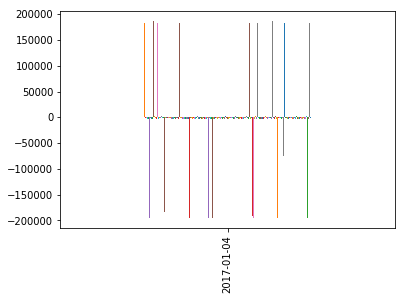

In [51]:
(shares_to_trade*prices).plot.bar(legend=False)

In [52]:
notl = shares_to_trade*prices.T[:-1].T
weights = notl/current_portfolio.USDOLLAR

In [53]:
shares_to_trade.shape

(452,)

In [54]:
prices.shape

(1, 453)

In [55]:
weights.shape

(1, 452)

In [56]:
factor_loadings.shape

(452, 8)

In [57]:
factor_loadings.T.dot(weights.T)

,2017-01-04
0,0.009731
1,0.010081
2,-0.010036
3,-0.010218
4,0.009028
5,0.008906
6,-0.010130
7,-0.007492


In [13]:
import numpy as np
import pandas as pd
import cvxportfolio as cp

np.random.seed(100)

factor_loadings = pd.get_dummies(pd.Series(np.random.randint(0,2,100)))

r_hat_s = pd.Series(np.random.random(100))
r_hat_s.T['USDOLLAR']=0
r_hat = pd.DataFrame(r_hat_s, columns=[pd.Timestamp('2017-01-03')]).T

prices_s = pd.Series(np.random.randint(20, 75, 100))
prices_noUSD = pd.DataFrame(prices_s, columns=[pd.Timestamp('2017-01-03')]).T
prices_s.T['USDOLLAR']=1.0
prices = pd.DataFrame(prices_s, columns=[pd.Timestamp('2017-01-03')]).T


spo_policy = cp.SinglePeriodOpt(
    return_forecast=r_hat,
    costs=[],
    constraints=[
        cp.LeverageLimit(1),
        cp.DollarNeutral(),
        cp.MaxWeights(0.10),
        cp.MinWeights(-0.10),
        cp.FactorMaxLimit(factor_loadings.values, 0.2),
        cp.FactorMinLimit(factor_loadings.values, 0.2)        
    ]
)

current_portfolio = pd.Series(index=r_hat.columns, data=0)
current_portfolio.USDOLLAR=100000

shares_to_trade = spo_policy.get_rounded_trades(
    current_portfolio,
    prices,
    t=pd.Timestamp('2017-01-04')
)

> /Users/jonathan/devwork/cvxportfolio/cvxportfolio/constraints.py(226)_weight_expr()
-> if isinstance(self.limit, pd.Series):
(Pdb) c


ERROR:root:The solver None failed. Defaulting to no trades


In [11]:
factor_loadings

,0,1
0,1,0
1,1,0
2,0,1
3,0,1
4,0,1
5,0,1
6,1,0
7,1,0
8,1,0
9,1,0


In [12]:
notl = shares_to_trade*prices_noUSD
weights = notl/current_portfolio.USDOLLAR

In [91]:
notl.abs().sum(axis=1)

2017-01-03    100033.0
dtype: float64

In [107]:
factor_loadings.T.dot(weights.T)

,2017-01-03 00:00:00
0,-0.19992
1,0.00000
2,0.10098
3,0.10047
4,0.00292
5,0.00046
